https://quickdraw.withgoogle.com/data/octopus

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np
import h5py

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Conv2D, AveragePooling2D, Reshape, Dense, BatchNormalization, Dropout, Flatten, UpSampling2D, Conv2DTranspose
from keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal
from keras import backend as K


from matplotlib import pyplot as plt
%matplotlib inline

# from pushbullet import Pushbullet

Using TensorFlow backend.


In [3]:
# data = np.load('./data/octopus.npy')
data = np.load('../quickdraw/apple.npy')
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

n = np.sort(np.random.choice(143557,10000,replace=False))
filename = '256x256_octopuses'
with h5py.File('./data/{}.hdf5'.format(filename),'r+') as f:
    data = f['rasters'][n,:,:,:]
    
img_w,img_h = data.shape[2:3]
    
print(data.shape)

n = np.random.randint(data.shape[0])
print(n)
sample_image = data[n]
plt.imshow(sample_image[:,:,0], cmap='Greys')

In [4]:
def discriminator_builder(depth=64,p=0.4):
    
    # Define initializer
    #init = TruncatedNormal(mean=0.0, stddev=0.02, seed=13)
    
    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

discriminator = discriminator_builder()

discriminator_model = discriminator
discriminator_model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0002, decay=6e-8), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [5]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    # Define initializer
    #init = TruncatedNormal(mean=0.0, stddev=0.02, seed=13)
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(axis=-1,momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(axis=-1,momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(axis=-1,momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    #conv3 = UpSampling2D()(conv2)
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(axis=-1,momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Define output layers
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

In [6]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'])
    model.summary()
    return model

AM = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [7]:
import os
output_dir = './images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
def train(epochs=2000,batch=128):
    for i in range(epochs):
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))
        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        d_loss = discriminator_model.train_on_batch(x,y)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])
        a_loss = AM.train_on_batch(noise,y)
        
        #log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
        #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
        #print(log_mesg)
        
        if (i+1)%1000 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(5,5))
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.savefig('./images/run3_{}.png'.format(i+1))

Epoch #1000
999: [D loss: 0.134807, acc: 0.945312]  [A loss: 4.512902, acc: 0.000000]


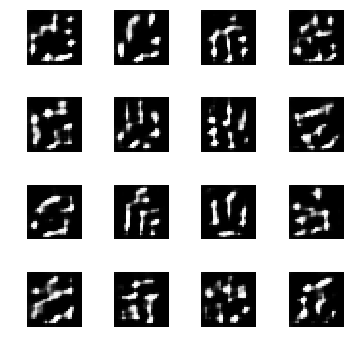

Epoch #2000
1999: [D loss: 0.842365, acc: 0.609375]  [A loss: 3.844110, acc: 0.000000]


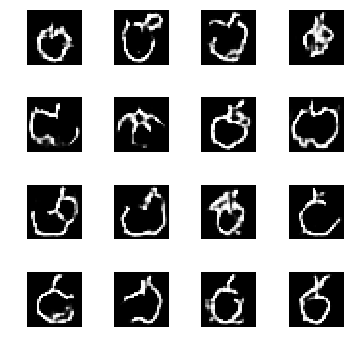

Epoch #3000
2999: [D loss: 0.547649, acc: 0.710938]  [A loss: 2.476388, acc: 0.015625]


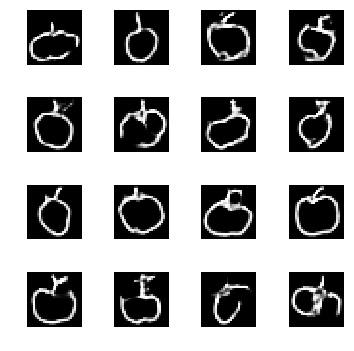

Epoch #4000
3999: [D loss: 0.483295, acc: 0.765625]  [A loss: 2.699296, acc: 0.046875]


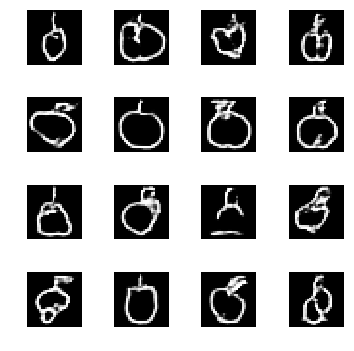

Epoch #5000
4999: [D loss: 0.482300, acc: 0.750000]  [A loss: 1.269386, acc: 0.343750]


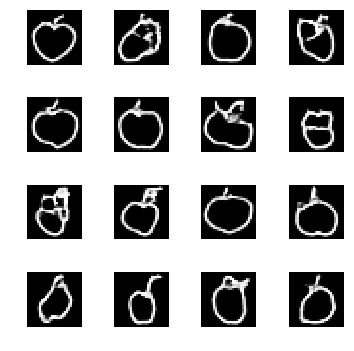

Epoch #6000
5999: [D loss: 0.501509, acc: 0.734375]  [A loss: 4.115008, acc: 0.000000]


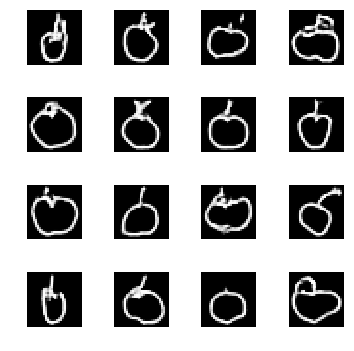

Epoch #7000
6999: [D loss: 0.329469, acc: 0.843750]  [A loss: 2.651914, acc: 0.031250]


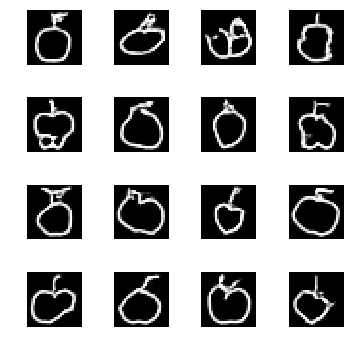

Epoch #8000
7999: [D loss: 0.383744, acc: 0.832031]  [A loss: 1.877843, acc: 0.171875]


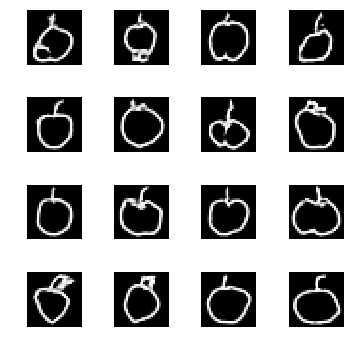

Epoch #9000
8999: [D loss: 0.447381, acc: 0.816406]  [A loss: 1.702852, acc: 0.164062]


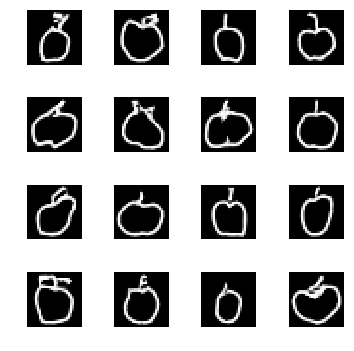

Epoch #10000
9999: [D loss: 0.478084, acc: 0.800781]  [A loss: 2.728219, acc: 0.062500]


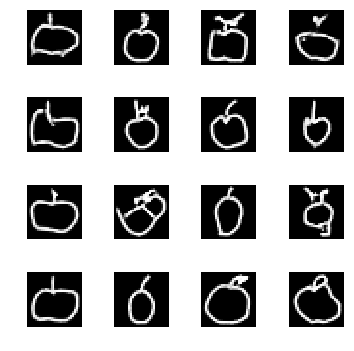

Epoch #11000
10999: [D loss: 0.725863, acc: 0.625000]  [A loss: 3.160723, acc: 0.015625]


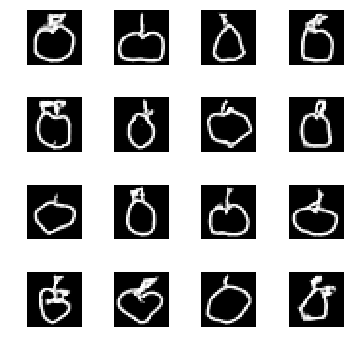

Epoch #12000
11999: [D loss: 0.653808, acc: 0.648438]  [A loss: 2.687958, acc: 0.039062]


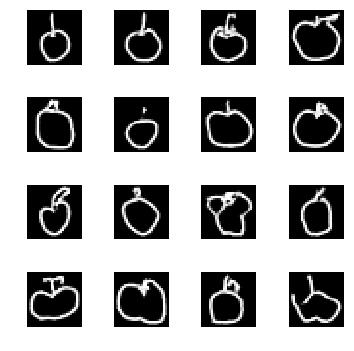

Epoch #13000
12999: [D loss: 0.505373, acc: 0.750000]  [A loss: 2.302705, acc: 0.062500]


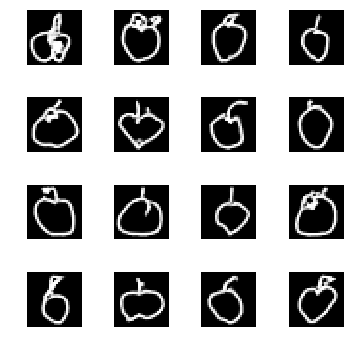

Epoch #14000
13999: [D loss: 0.704076, acc: 0.621094]  [A loss: 3.018622, acc: 0.007812]


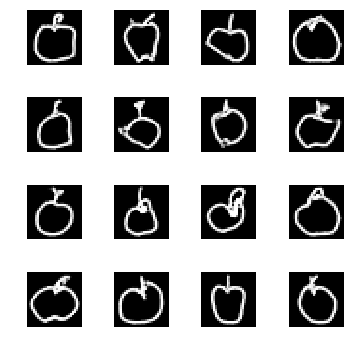

Epoch #15000
14999: [D loss: 0.596080, acc: 0.675781]  [A loss: 2.511618, acc: 0.023438]


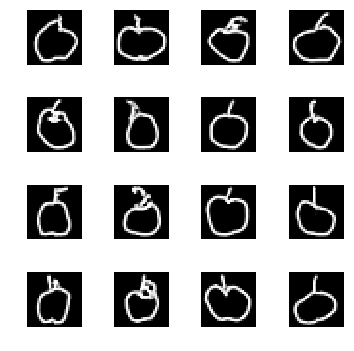

Epoch #16000
15999: [D loss: 0.814809, acc: 0.605469]  [A loss: 2.139711, acc: 0.039062]


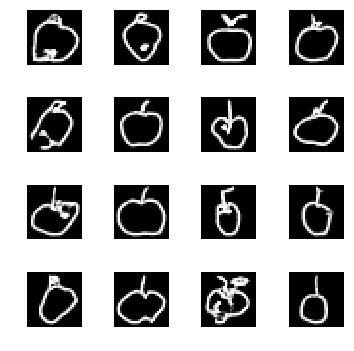

Epoch #17000
16999: [D loss: 0.746233, acc: 0.636719]  [A loss: 2.501797, acc: 0.007812]


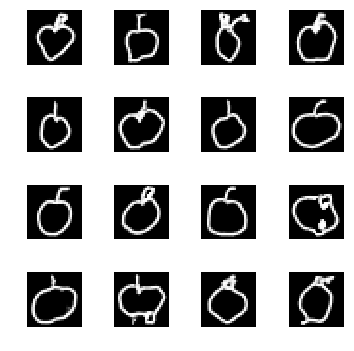

Epoch #18000
17999: [D loss: 0.699940, acc: 0.691406]  [A loss: 2.330208, acc: 0.031250]


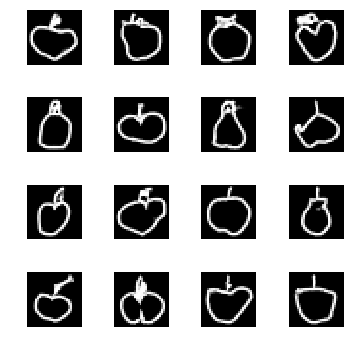

Epoch #19000
18999: [D loss: 0.613205, acc: 0.703125]  [A loss: 2.343870, acc: 0.023438]


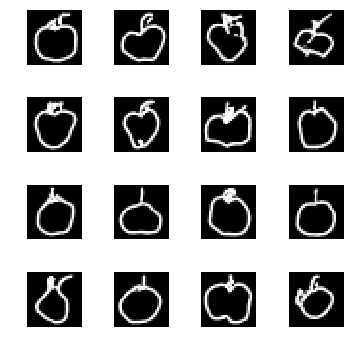

Epoch #20000
19999: [D loss: 0.537749, acc: 0.746094]  [A loss: 1.729286, acc: 0.132812]


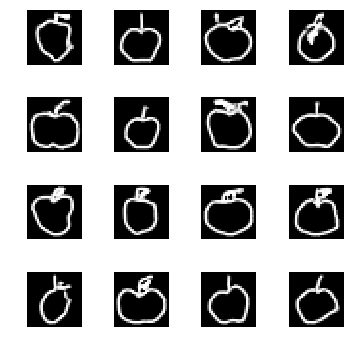

In [9]:
train(epochs=20000)

noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
gen_imgs = generator.predict(noise)
plt.figure(figsize=(5,5))
for k in range(gen_imgs.shape[0]):
    plt.subplot(4, 4, k+1)
    #image = gen_imgs[i, :, :, :]
    #image = np.reshape(gen_imgs, [self.img_rows, self.img_cols])
    plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()